In [1]:
import os
from datetime import datetime
from typing import Dict, Tuple, Any
from tqdm import tqdm

import math
import numpy as np
import pandas as pd

import cv2
import albumentations
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

import timm

from warmup_scheduler import GradualWarmupScheduler

In [2]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [11]:
del model, optimizer_ha, scheduler_cosine, scheduler_ha, optimizer_std, scheduler_std

In [8]:
n_epochs = 100
n_steps = 10
model = nn.Linear(10, 20)
optimizer_ha = torch.optim.Adam(model.parameters(), lr=1)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ha, T_0=1)
scheduler_ha = GradualWarmupSchedulerV2(optimizer_ha, multiplier=10, total_epoch=n_epochs, after_scheduler=scheduler_cosine)
optimizer_std = torch.optim.Adam(model.parameters(), lr=1)
scheduler_std = OneCycleLR(optimizer_std, max_lr=1, steps_per_epoch=n_steps, pct_start=0.1, epochs=n_epochs)

In [9]:
ha_history = []
std_history = []

for epoch in range(n_epochs):
    scheduler_ha.step(epoch)
    for _ in range(n_steps):
        scheduler_std.step()
        ha_history.append(optimizer_ha.param_groups[0]["lr"])
        std_history.append(optimizer_std.param_groups[0]["lr"])

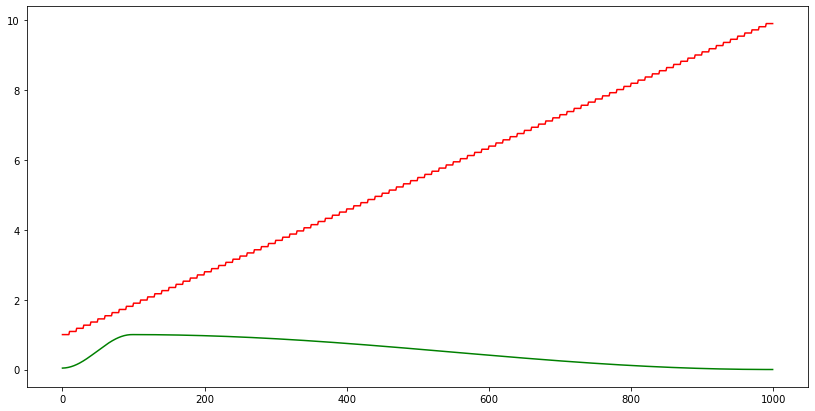

In [10]:
_, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(ha_history, c='r')
ax.plot(std_history, c='g')

In [ ]:
del model, optimizer_ha, scheduler_cosine, scheduler_ha, optimizer_std, scheduler_std

In [8]:
n_epochs = 100
n_steps = 10
model = nn.Linear(10, 20)
optimizer_ha = torch.optim.Adam(model.parameters(), lr=1)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ha, T_0=1)
scheduler_ha = GradualWarmupSchedulerV2(optimizer_ha, multiplier=10, total_epoch=n_epochs, after_scheduler=scheduler_cosine)